## Cleaning, Normalizing, Cropping and Export DICOM Images

In [1]:
import os
import cv2

import pydicom
import pandas as pd
import numpy as np 
import torch
import matplotlib.pyplot as plt 
from pathlib import Path
import scipy.ndimage as ndimage
from skimage import measure, morphology, segmentation
from scipy.ndimage.interpolation import zoom
from PIL import Image 

from tqdm.notebook import tqdm
%matplotlib inline

from fastai.basics import *
from fastai.medical.imaging import *

import pickle as pkl

In [3]:
data_dir = Path('osic-pulmonary-fibrosis-progression/')
patient_paths = (data_dir/'train').ls()
sample_patient = patient_paths[0]

In [2]:
with open('training_dicom_metadata.pkl', 'rb') as f:
    dicom_meta = pkl.load(f)

dicom_meta.head().T

,0,1,2,3,4
SpecificCharacterSet,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100
ImageType,ORIGINAL,ORIGINAL,ORIGINAL,ORIGINAL,ORIGINAL
SOPInstanceUID,2.25.12297650151329871895440507938349160734,2.25.37611372879908126511187998276199853341,2.25.85307440096263309601052352542310417307,2.25.46123781426224593247761081441512910006,2.25.116080798158038264329904205296840554047
Modality,CT,CT,CT,CT,CT
Manufacturer,GE MEDICAL SYSTEMS,GE MEDICAL SYSTEMS,GE MEDICAL SYSTEMS,GE MEDICAL SYSTEMS,GE MEDICAL SYSTEMS
...,...,...,...,...,...
ImageType7,NaN,NaN,NaN,NaN,NaN
ImageType8,NaN,NaN,NaN,NaN,NaN
SpatialResolution,NaN,NaN,NaN,NaN,NaN
MultiConvolutionKernel,NaN,NaN,NaN,NaN,NaN


In [4]:
def generate_markers(image):
    """
    Generates markers for a given image.
    
    Parameters: image
    
    Returns: Internal Marker, External Marker, Watershed Marker
    """
    
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    
    marker_internal = marker_internal_labels > 0
    
    # Creation of the External Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    
    # Creation of the Watershed Marker
    marker_watershed = np.zeros(image.shape, dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed


def seperate_lungs(image, iterations = 1):
    """
    Segments lungs using various techniques.
    
    Parameters: image (Scan image), iterations (more iterations, more accurate mask)
    
    Returns: 
        - Segmented Lung
        - Lung Filter
        - Outline Lung
        - Watershed Lung
        - Sobel Gradient
    """
    
    # Store the start time
    # start = time.time()
    
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    
    '''
    Creation of Sobel Gradient
    '''
    
    # Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    
    '''
    Using the watershed algorithm
    
    
    We pass the image convoluted by sobel operator and the watershed marker
    to morphology.watershed and get a matrix matrix labeled using the 
    watershed segmentation algorithm.
    '''
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    '''
    Reducing the image to outlines after Watershed algorithm
    '''
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    
    '''
    Black Top-hat Morphology:
    
    The black top hat of an image is defined as its morphological closing
    minus the original image. This operation returns the dark spots of the
    image that are smaller than the structuring element. Note that dark 
    spots in the original image are bright spots after the black top hat.
    '''
    
    # Structuring element used for the filter
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, iterations)
    
    # Perform Black Top-hat filter
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    '''
    Generate lung filter using internal marker and outline.
    '''
    lungfilter = np.bitwise_or(marker_internal, outline)
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    '''
    Segment lung using lungfilter and the image.
    '''
    segmented = np.where(lungfilter == 1, image, -2000*np.ones(image.shape))
    
    return segmented, lungfilter, outline, watershed, sobel_gradient

In [5]:
#DICOM Read utils
def fix_pxrepr(dcm):
    if dcm.PixelRepresentation != 0 or dcm.RescaleIntercept<-100:
        return dcm
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000
    return dcm

def read_dcm(path):
    dcm = fix_pxrepr(Path(path).dcmread())
    if dcm.Rows != 512 or dcm.Columns != 512: 
        dcm.zoom_to((512,512))
    return dcm


# Generate JPGs
def get_maskedlung_scan_img(path):
    dcm = read_dcm(path)
    _, lungmask, _, _, _ = seperate_lungs(dcm.scaled_px.numpy())
    masked_lung = torch.tensor(np.where(lungmask, dcm.scaled_px, -2048))
    return dcm, masked_lung

def save_maskedlung_lungimg(path, masked_path, img_path, masked_bins=None, bins=None):
    dcm, masked_lung = get_maskedlung_scan_img(path)
    save_jpg(masked_lung, masked_path, masked_bins)
    save_jpg(dcm, img_path, bins)
    
    
def save_jpg(img, path, bins):
    windows = [dicom_windows.lungs,dicom_windows.subdural]
    img.save_jpg(path, windows, bins=bins)
    
def read_jpg(path):
    return np.array(Image.open(str(path)))

In [6]:
dicom_meta['image_format'] = dicom_meta.PixelRepresentation.astype(str) + '_' + dicom_meta.BitsStored.astype(str)
dicom_meta['image_format'].value_counts().to_dict()

{&#39;1_16&#39;: 15002, &#39;0_12&#39;: 14631, &#39;0_16&#39;: 3140, &#39;1_13&#39;: 253}

In [7]:
format_df = dicom_meta[['image_format', 'fname']]
selected_files = []
for img_format, n in format_df['image_format'].value_counts().to_dict().items():
    selected_files += list(format_df.loc[format_df['image_format'] == str(img_format)].sample(min(1000, n // 3))['fname'])

selected_files[0:5]

[&#39;osic-pulmonary-fibrosis-progression\\train\\ID00078637202199415319443\\35.dcm&#39;,
 &#39;osic-pulmonary-fibrosis-progression\\train\\ID00202637202249376026949\\194.dcm&#39;,
 &#39;osic-pulmonary-fibrosis-progression\\train\\ID00241637202264294508775\\12.dcm&#39;,
 &#39;osic-pulmonary-fibrosis-progression\\train\\ID00180637202240177410333\\176.dcm&#39;,
 &#39;osic-pulmonary-fibrosis-progression\\train\\ID00078637202199415319443\\54.dcm&#39;]

In [8]:
def get_scan_freqhist_bins():
    sample_images = []
    for path in tqdm(selected_files):
        try:
            dcm = read_dcm(path)
            sample_images.append(dcm.scaled_px)
        except Exception as e:
            print(e)
    samples_arr = torch.stack(sample_images)
    del sample_images
    bins = samples_arr.freqhist_bins()
    del samples_arr
    return bins

In [20]:
bins = get_scan_freqhist_bins()
with open('bins.pkl', 'wb') as f:
    pkl.dump(bins, f)
bins

tensor([-4096., -3024., -2048., -2000., -1072., -1024., -1022., -1019., -1016.,
        -1013., -1010., -1007., -1005., -1002., -1000.,  -998.,  -995.,  -993.,
         -990.,  -988.,  -984.,  -981.,  -977.,  -973.,  -968.,  -963.,  -958.,
         -952.,  -946.,  -940.,  -933.,  -926.,  -918.,  -911.,  -903.,  -894.,
         -885.,  -874.,  -861.,  -845.,  -826.,  -803.,  -773.,  -733.,  -676.,
         -594.,  -485.,  -371.,  -290.,  -239.,  -204.,  -179.,  -160.,  -145.,
         -134.,  -124.,  -115.,  -107.,  -100.,   -92.,   -84.,   -77.,   -68.,
          -60.,   -51.,   -41.,   -32.,   -23.,   -14.,    -6.,     0.,     6.,
           14.,    21.,    28.,    35.,    42.,    48.,    55.,    62.,    70.,
           79.,    89.,   102.,   117.,   136.,   160.,   192.,   235.,   300.,
          415.,   747.,  1270.])

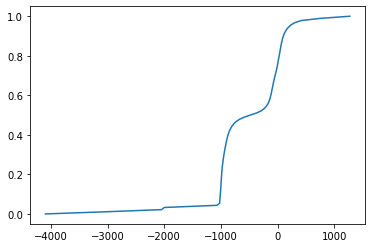

In [9]:
with open('bins.pkl', 'rb') as f:
    bins = pkl.load(f)
plt.plot(bins, torch.linspace(0,1,len(bins)));

In [10]:
def get_maskedscan_freqhist_bins():
    sample_masked_images = []
    for path in tqdm(selected_files):
        try:
            dcm = read_dcm(path)
            dcm_np = dcm.scaled_px.numpy()
            _, lungmask, _, _, _ = seperate_lungs(dcm_np)
            masked_lung = torch.tensor(np.where(lungmask, dcm_np, -2048))
            sample_masked_images.append(masked_lung)
        except Exception as e:
            print(e)
    sample_mask_arr = torch.stack(sample_masked_images)
    del sample_masked_images
    masked_bins = sample_mask_arr.freqhist_bins()
    del sample_mask_arr
    return masked_bins

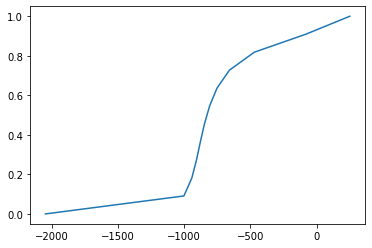

In [23]:
masked_bins = get_maskedscan_freqhist_bins()
with open('masked_bins.pkl', 'wb') as f:
    pkl.dump(masked_bins, f)

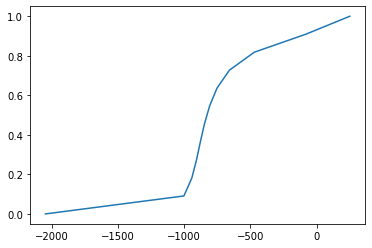

In [11]:
with open('masked_bins.pkl', 'rb') as f:
    masked_bins = pkl.load(f)
plt.plot(masked_bins, torch.linspace(0,1,len(masked_bins)));

## Normalized Array to JPG
First two channels are filled with windowed CT scans, 3rd channel is histogram sacaled values with generated `bins`

In [12]:
!mkdir osic-pulmonary-fibrosis-progression-segmentation-jpgs;
!mkdir osic-pulmonary-fibrosis-progression-segmentation-jpgs\train;
!mkdir osic-pulmonary-fibrosis-progression-segmentation-jpgs\train\scans;
!mkdir osic-pulmonary-fibrosis-progression-segmentation-jpgs\train\masked_scans;

In [13]:
output_dir = Path('osic-pulmonary-fibrosis-progression-segmentation-jpgs/train')
output_dir_scans = output_dir/'scans'
output_dir_mscans = output_dir/'masked_scans'

In [14]:
patient_dirs = (data_dir/'train').ls()
len(patient_dirs)

176

In [15]:
import traceback
import shutil

def create_a_zip_archive(i, patient_dir_batch):
    for patient in tqdm(patient_dir_batch):
        patient_id = str(patient).split('\\')[-1]
        (output_dir_scans/patient_id).mkdir(parents=True, exist_ok=True)
        (output_dir_mscans/patient_id).mkdir(parents=True, exist_ok=True)
        for img_path in patient.glob('*'):
            try:
                img_id = str(img_path).split('\\')[-1][:-4]
                if not (output_dir_mscans/patient_id/f'{img_id}.jpg').exists():
                    save_maskedlung_lungimg(
                        img_path, 
                        output_dir_mscans/patient_id/f'{img_id}.jpg',
                        output_dir_scans/patient_id/f'{img_id}.jpg',
                        masked_bins,
                        bins
                    )
            except Exception as e:
                traceback.print_exc()
                print(e)
                print(img_path)
    shutil.make_archive(f'lung_segmentation_scans_{i}', 'zip', str(output_dir))
    shutil.rmtree(str(output_dir_scans))
    shutil.rmtree(str(output_dir_mscans))

In [17]:
n = 10
start_n = 0
for i, n_start in enumerate(range(start_n, len(patient_dirs), n)):
    create_a_zip_archive(i + int(start_n / n), patient_dirs[n_start: n_start + n])

In [18]:
!mkdir osic-pulmonary-fibrosis-progression-segmentation-jpgs\test;
!mkdir osic-pulmonary-fibrosis-progression-segmentation-jpgs\test\scans;
!mkdir osic-pulmonary-fibrosis-progression-segmentation-jpgs\test\masked_scans;

In [19]:
output_dir = Path('osic-pulmonary-fibrosis-progression-segmentation-jpgs/test')
output_dir_scans = output_dir/'scans'
output_dir_mscans = output_dir/'masked_scans'

In [20]:
patient_dirs = (data_dir/'test').ls()
len(patient_dirs)

5

In [21]:
n = 10
start_n = 0
for i, n_start in enumerate(range(start_n, len(patient_dirs), n)):
    create_a_zip_archive(i + int(start_n / n), patient_dirs[n_start: n_start + n])